In [1]:
import os, sys
import copy
import json
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Prepare the data

In [3]:
data_dir = '../../data/processed'

metadata_filepath = f'{data_dir}/metadata.json'
with open(metadata_filepath, 'r') as rfile:
    data = rfile.read()
metadata = json.loads(data)

In [4]:
CLASSES_LABELS = metadata['CLASSES_LABELS']

In [5]:
data_filepath = f'{data_dir}/imgs_data01.csv'
df = pd.read_csv(data_filepath)
df

,ID,img_filepath,split,round_number,target
0,7,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,train,1,0
1,8,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,train,3,1
2,8,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,train,4,0
3,8,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,train,5,1
4,18,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,valid,1,0
...,...,...,...,...,...
22289,30789,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,train,1,1
22290,30790,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,test,1,0
22291,30792,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,valid,2,0
22292,30792,c:/Users/weldl/Workspace/IFSP-Final-Project/da...,valid,4,0


In [10]:
class MyDataset(Dataset):
    def __init__(self, dataframe, split, round_number):
        self.split = split
        self.round_number = round_number
        self.dataframe = dataframe[(dataframe['split'] == split) & (dataframe['round_number'] <= round_number)].reset_index(drop=True)
        self.image_names = dataframe["img_filepath"].values
        self.labels = torch.FloatTensor(dataframe["target"].values)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image = Image.open(self.image_names[index]).convert('RGB')
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        image = preprocess(image)
        
        return image, self.labels[index]

In [11]:
round_number = 1
train_set = MyDataset(df, 'train', round_number)
valid_set = MyDataset(df, 'valid', round_number)
test_set = MyDataset(df, 'test', round_number)

print('train_set size:', train_set.__len__())
print('valid_set size:', valid_set.__len__())
print('test_set size:', test_set.__len__())
print('total:', train_set.__len__() + valid_set.__len__() + test_set.__len__())

train_set size: 5576
valid_set size: 1634
test_set size: 1661
total: 8871


In [12]:
# Setting the dataloaders:
train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=1, shuffle=False)
test_dl = DataLoader(test_set, batch_size=1, shuffle=False)

dataset_sizes = {'train': train_set.__len__(), 'valid': valid_set.__len__(), 'test': test_set.__len__()}
dataloaders = {'train': train_dl, 'valid': valid_dl, 'test': test_dl}

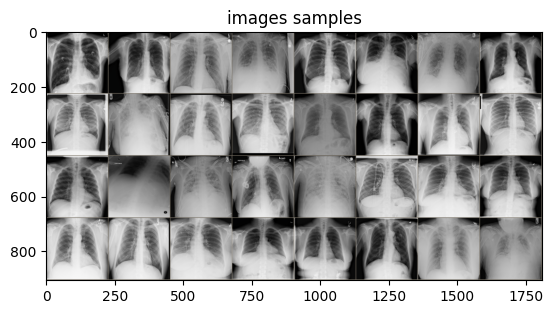

In [13]:
### Visualize a few images
# Let's visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='images samples')

## Set the Model

In [14]:
class DenseNet121(nn.Module):
    def __init__(self, n_classes=1):
        super(DenseNet121, self).__init__()
        self.model = torchvision.models.densenet121(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, n_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
model = DenseNet121()
model = model.to(device)

C:\Users\weldl\Miniconda3\envs\federated\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\weldl\Miniconda3\envs\federated\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train the model

In [16]:
def train_model(model, dataloaders, dataset_sizes,
                criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model_hist = []

    for epoch in range(num_epochs):
        since_epoch = time.time()
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        epoch_perf = {'epoch': epoch}
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # _, preds = torch.max(outputs, 1)
                    preds = outputs.round()
                    loss = criterion(outputs, labels.reshape(len(labels), 1))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.reshape(len(preds)) == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            epoch_perf[f'{phase}_loss'] = epoch_loss
            epoch_perf[f'{phase}_acc'] = epoch_acc

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        model_hist.append(epoch_perf)
        time_elapsed_epoch = time.time() - since_epoch
        print(f'{time_elapsed_epoch // 60:.0f}m {time_elapsed_epoch % 60:.0f}s/epoch\n')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, pd.DataFrame(model_hist)

In [17]:
num_epochs=25

criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # RMSprop, Adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
model, model_hist = train_model(model, dataloaders, dataset_sizes,
                                criterion, optimizer, exp_lr_scheduler,
                                num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.6624 Acc: 0.6047
valid Loss: 0.6213 Acc: 0.6720
1m 25s/epoch

Epoch 1/24
----------
train Loss: 0.6273 Acc: 0.6521
valid Loss: 0.6629 Acc: 0.6157
1m 23s/epoch

Epoch 2/24
----------
train Loss: 0.6155 Acc: 0.6603
valid Loss: 0.5973 Acc: 0.6897
1m 26s/epoch

Epoch 3/24
----------
train Loss: 0.6102 Acc: 0.6673
valid Loss: 0.5895 Acc: 0.7001
1m 29s/epoch

Epoch 4/24
----------
train Loss: 0.6085 Acc: 0.6684
valid Loss: 0.5868 Acc: 0.7007
1m 29s/epoch

Epoch 5/24
----------
train Loss: 0.6029 Acc: 0.6786
valid Loss: 0.5833 Acc: 0.7062
1m 31s/epoch

Epoch 6/24
----------
train Loss: 0.6023 Acc: 0.6743
valid Loss: 0.5803 Acc: 0.7075
1m 30s/epoch

Epoch 7/24
----------
train Loss: 0.5892 Acc: 0.6951
valid Loss: 0.5807 Acc: 0.6977
1m 29s/epoch

Epoch 8/24
----------
train Loss: 0.5929 Acc: 0.6847
valid Loss: 0.5834 Acc: 0.6916
1m 29s/epoch

Epoch 9/24
----------
train Loss: 0.5912 Acc: 0.6883
valid Loss: 0.5806 Acc: 0.7013
1m 30s/epoch

Epoch 10/24
--------

In [19]:
def plot_model_hist(historic, title=''):

    plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plt.title(title+' loss')
    plt.plot(historic['train_loss'], label='train loss')
    plt.plot(historic['valid_loss'], label='valid. loss')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(1,2,2)
    plt.title(title+' acc')
    plt.plot(historic['train_acc'], label='train acc')
    plt.plot(historic['valid_acc'], label='valid. acc')
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("acc")

    plt.show()

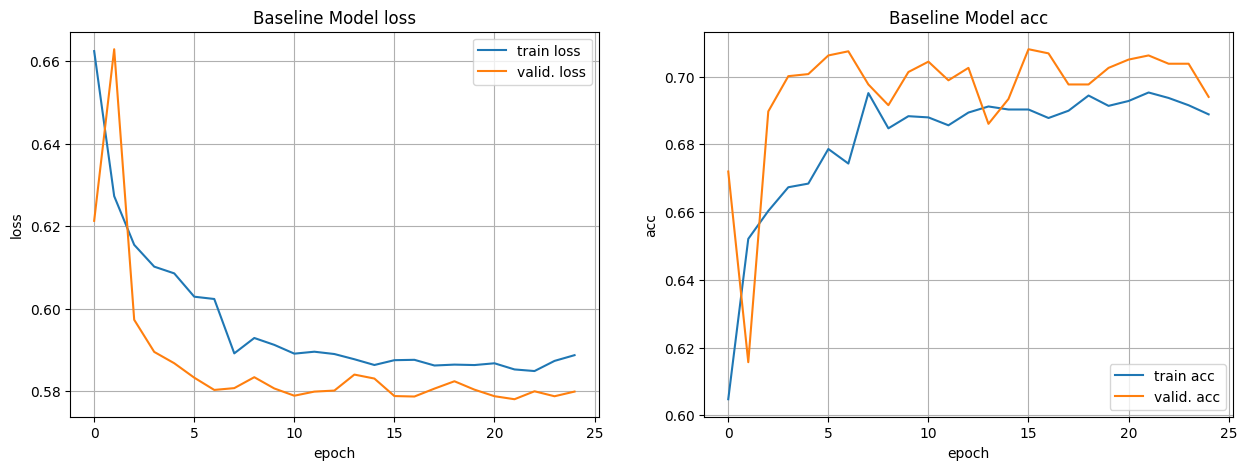

In [20]:
plot_model_hist(model_hist, 'Baseline Model')

## Evaluate model predictions

In [21]:
def evaluate_model(model, dataloaders, dataset_sizes, split='test'):
    model.eval()
    running_corrects = 0
    for i, (inputs, labels) in enumerate(dataloaders[split]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # _, preds = torch.max(outputs, 1)
        preds = outputs.round()
        running_corrects += torch.sum(preds.reshape(len(preds)) == labels.data)

    eval_acc = running_corrects.double() / dataset_sizes[split]
    print(f'Accuracy on {split} set: %.3f' % eval_acc)
    
evaluate_model(model, dataloaders, dataset_sizes, split='test')

Accuracy on test set: 0.709


## Saving current model:

In [22]:
db_number = data_filepath.split('/')[-1].split('.')[0].replace('imgs_data', '')
model_tag = f'db{db_number}_round{round_number}_{datetime.now().year}-{datetime.now().month}-{datetime.now().day} {datetime.now().hour}h{datetime.now().minute}m{datetime.now().second}s'
modelpath = f'./{model_tag}.pth'
torch.save(model.state_dict(), modelpath)
print(f'{modelpath} saved')

./db01_round1_2022-9-25 13h11m36s.pth saved
